In [1]:
import numpy as np
import pandas as pd
import os
from collections import Counter
import matplotlib.pyplot as plt
import statistics

import time
import warnings

# From https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# and https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
from sklearn.model_selection import train_test_split
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import label_binarize
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD

from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, recall_score
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
warnings.filterwarnings('ignore')

In [3]:
def d2h(actual, preds):
    tn, fp, fn, tp = confusion_matrix(actual, preds, labels=[0,1]).ravel()
    #print('TP =', tp, '| TN =', tn, '| FP =', fp, '| FN =', fn)
    fpr = fp * 1.0 / (tn + fp) if (tn + fp) != 0 else 0
    rec = 1.0 * tp / (tp + fn) if (tp + fn) != 0 else 0
    
    return np.sqrt(fpr ** 2 + (1 - rec) ** 2) / np.sqrt(2)

In [4]:
def get_auc(actual, preds, classes):
    return roc_auc_score(label_binarize(actual, classes), label_binarize(preds, classes))

In [5]:
def get_fpr(actual, preds):
    tn, fp, fn, tp = confusion_matrix(actual, preds, labels=[0,1]).ravel()
    fpr = fp * 1.0 / (tn + fp) if (tn + fp) != 0 else 0
    
    return fpr

In [6]:
def subtotal(x):
    xx = [0]
    for i, t in enumerate(x):
        xx += [xx[-1] + t]
    return xx[1:]


def get_recall(true):
    total_true = float(len([i for i in true if i == 1]))
    hit = 0.0
    recall = []
    for i in range(len(true)):
        if true[i] == 1:
            hit += 1
        recall += [hit / total_true if total_true else 0.0]
    return recall

In [7]:
def get_popt20(data):
    data.sort_values(by=["bug", "loc"], ascending=[0, 1], inplace=True)
    x_sum = float(sum(data['loc']))
    x = data['loc'].apply(lambda t: t / x_sum)
    xx = subtotal(x)

    # get  AUC_optimal
    yy = get_recall(data['bug'].values)
    xxx = [i for i in xx if i <= 0.2]
    yyy = yy[:len(xxx)]
    s_opt = round(auc(xxx, yyy), 3)

    # get AUC_worst
    xx = subtotal(x[::-1])
    yy = get_recall(data['bug'][::-1].values)
    xxx = [i for i in xx if i <= 0.2]
    yyy = yy[:len(xxx)]
    try:
        s_wst = round(auc(xxx, yyy), 3)
    except:
        # print "s_wst forced = 0"
        s_wst = 0
    
    # get AUC_prediction
    data.sort_values(by=["prediction", "loc"], ascending=[0, 1], inplace=True)
    x = data['loc'].apply(lambda t: t / x_sum)
    xx = subtotal(x)
    yy = get_recall(data['bug'].values)
    xxx = [k for k in xx if k <= 0.2]
    yyy = yy[:len(xxx)]
    try:
        s_m = round(auc(xxx, yyy), 3)
    except:
        return 0
    
    Popt = (s_m - s_wst) / (s_opt - s_wst)
    return round(Popt,3)

In [8]:
# from https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        return K.mean(
            K.binary_crossentropy(y_true, y_pred) * weights)
    
    return loss

In [9]:
base_path = '../Dodge_DL/Dodge/data/defect/'

In [10]:
file_dic = {"ivy": ["ivy-1.1.csv", "ivy-1.4.csv", "ivy-2.0.csv"],
            "lucene": ["lucene-2.0.csv", "lucene-2.2.csv", "lucene-2.4.csv"],
            "poi": ["poi-1.5.csv", "poi-2.0.csv", "poi-2.5.csv", "poi-3.0.csv"],
            "synapse": ["synapse-1.0.csv", "synapse-1.1.csv", "synapse-1.2.csv"],
            "velocity": ["velocity-1.4.csv", "velocity-1.5.csv", "velocity-1.6.csv"],
            "camel": ["camel-1.0.csv", "camel-1.2.csv", "camel-1.4.csv", "camel-1.6.csv"],
            "jedit": ["jedit-3.2.csv", "jedit-4.0.csv", "jedit-4.1.csv", "jedit-4.2.csv", "jedit-4.3.csv"],
            "log4j": ["log4j-1.0.csv", "log4j-1.1.csv", "log4j-1.2.csv"],
            "xalan": ["xalan-2.4.csv", "xalan-2.5.csv", "xalan-2.6.csv", "xalan-2.7.csv"],
            "xerces": ["xerces-1.2.csv", "xerces-1.3.csv", "xerces-1.4.csv"]
           }

In [11]:
def get_class_imbalance(filename, epochs=10, layers=4):
    paths = [os.path.join(base_path, file_name) for file_name in file_dic[filename]]
    train_df = pd.concat([pd.read_csv(path) for path in paths[:-1]], ignore_index=True)
    test_df = pd.read_csv(paths[-1])
    
    train_df, test_df = train_df.iloc[:, 3:], test_df.iloc[:, 3:]
    train_size = train_df["bug"].count()
    df = pd.concat([train_df, test_df], ignore_index=True)
    df['bug'] = df['bug'].apply(lambda x: 0 if x == 0 else 1)
    
    train_data = df.iloc[:train_size, :]
    test_data = df.iloc[train_size:, :]
    
    X_train = train_data[train_data.columns[:-2]]
    y_train = train_data['bug']
    X_test = test_data[test_data.columns[:-2]]
    y_test = test_data['bug']
    
    print(np.mean(y_train))
    print(np.mean(y_test))

In [17]:
for file in file_dic.keys():
    print(file)
    get_class_imbalance(file)

ivy
0.22443181818181818
0.11363636363636363
lucene
0.5316742081447964
0.5970588235294118
poi
0.4551282051282051
0.6357466063348416
synapse
0.20052770448548812
0.3359375
velocity
0.7048780487804878
0.3406113537117904
camel
0.205607476635514
0.19481865284974093
jedit
0.23229912490055687
0.022357723577235773
log4j
0.29098360655737704
0.9219512195121952
xalan
0.3766072169224388
0.9878987898789879
xerces
0.15677491601343785
0.7431972789115646


In [12]:
def run_scalability_tests(filename, epochs=10, layers=4):
    paths = [os.path.join(base_path, file_name) for file_name in file_dic[filename]]
    train_df = pd.concat([pd.read_csv(path) for path in paths[:-1]], ignore_index=True)
    test_df = pd.read_csv(paths[-1])
    
    train_df, test_df = train_df.iloc[:, 3:], test_df.iloc[:, 3:]
    train_size = train_df["bug"].count()
    df = pd.concat([train_df, test_df], ignore_index=True)
    df['bug'] = df['bug'].apply(lambda x: 0 if x == 0 else 1)
    
    X_train = df[df.columns[:-2]]
    y_train = df['bug']
    
    frac = sum(y_train) * 1.0 / len(y_train)
    weights = np.array([1., 1. / frac])
                
    model = Sequential()
    model.add(Dense(20, input_shape=(X_train.shape[1],), activation='relu', name='layer1'))
    
    for i in range(layers - 2):
        model.add(Dense(20, activation='relu', name='layer'+str(i+2)))
        
    model.add(Dense(1, activation='sigmoid', name='layer'+str(layers)))
    model.compile(loss=weighted_categorical_crossentropy(weights), optimizer='adam', metrics=['accuracy'])

    batch_size = 64

    times = []
    for i in range(1, 11):
        frac = train_size // 10 * i
        a = time.process_time()
        model.compile(loss=weighted_categorical_crossentropy(weights), optimizer='adam', metrics=['accuracy'])
        model.fit(X_train.iloc[:frac, :], y_train.iloc[:frac], epochs=epochs, batch_size=batch_size,validation_split=0.1, verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001)])
        times.append(time.process_time() - a)
    
    return times

In [13]:
def run_on_dataset(filename, metric='d2h', epochs=10, layers=4, draw_roc=False, weighted=False):
    paths = [os.path.join(base_path, file_name) for file_name in file_dic[filename]]
    train_df = pd.concat([pd.read_csv(path) for path in paths[:-1]], ignore_index=True)
    test_df = pd.read_csv(paths[-1])
    
    train_df, test_df = train_df.iloc[:, 3:], test_df.iloc[:, 3:]
    train_size = train_df["bug"].count()
    df = pd.concat([train_df, test_df], ignore_index=True)
    df['bug'] = df['bug'].apply(lambda x: 0 if x == 0 else 1)
    
    train_data = df.iloc[:train_size, :]
    test_data = df.iloc[train_size:, :]
    
    X_train = train_data[train_data.columns[:-2]]
    y_train = train_data['bug']
    X_test = test_data[test_data.columns[:-2]]
    y_test = test_data['bug']
    
    frac = sum(y_train) * 1.0 / len(y_train)
    if weighted:
        weights = np.array([1., 0.1 / frac])
    else:
        weights = np.array([1., 1.])
                
    model = Sequential()
    model.add(Dense(20, input_shape=(X_train.shape[1],), activation='relu', name='layer1'))
    
    for i in range(layers - 2):
        model.add(Dense(20, activation='relu', name='layer'+str(i+2)))
        
    model.add(Dense(1, activation='sigmoid', name='layer'+str(layers)))
    model.compile(loss=weighted_categorical_crossentropy(weights), optimizer='adam', metrics=['accuracy'])

    batch_size = 64

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001)])
    
    y_pred = model.predict_classes(X_test)
    
    if metric == 'd2h':
        metric_ = d2h(y_test, y_pred)
    elif metric == 'fpr':
        metric_ = get_fpr(y_test, y_pred)
    elif metric == 'recall':
        metric_ = recall_score(y_test, y_pred)
    elif metric == 'auc':
        metric_ = get_auc(y_test, y_pred, classes=[0,1])
    elif metric == 'popt':
        x_sum = sum(X_test['loc'])
        x = X_test['loc'].apply(lambda t: t / x_sum)
        xx = subtotal(x)
        yy = get_recall(test_data['bug'].values)
        metric_ = auc(xx, yy)
    elif metric == 'popt20':
        test_data.loc[:,"prediction"]=y_pred
        metric_ = get_popt20(test_data)
    
    if draw_roc:
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        print('AUC =', auc(fpr, tpr))
        print(metric, '=', metric_)
        plt.plot(fpr, tpr, color='darkorange')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    
    return history, metric_

In [15]:
for dataset in file_dic.keys():
    print(dataset)
    print('=' * len(dataset))
    for metric in ['fpr', 'popt20', 'recall', 'auc']:
        values = []
        for i in range(20):
            _, metric_ = run_on_dataset(filename=dataset, metric=metric, epochs=10, layers=4)
            values.append(metric_)
        
        print(metric, '-', values)
    
    print()

ivy
===
fpr - [0.060897435897435896, 0.01282051282051282, 0.21474358974358973, 0.38782051282051283, 0.32371794871794873, 0.2916666666666667, 0.33974358974358976, 0.125, 0.2980769230769231, 0.1346153846153846, 0.3717948717948718, 0.2692307692307692, 0.24358974358974358, 0.07371794871794872, 0.11538461538461539, 0.08012820512820513, 0.3076923076923077, 0.057692307692307696, 0.5224358974358975, 0.34294871794871795]
popt20 - [0.16, 0.076, 0.092, 0.261, 0.286, 0.227, 0.176, 0.067, 0.16, 0.084, 0.151, 0.151, 0.235, 0.193, 0.109, 0.294, 0.21, 0.244, 0.126, 0.143]
recall - [0.15, 0.4, 0.425, 0.125, 0.475, 0.325, 0.225, 0.35, 0.325, 0.2, 0.35, 0.25, 0.225, 0.125, 0.5, 0.45, 0.175, 0.675, 0.15, 0.35]
auc - [0.6054487179487179, 0.5942307692307691, 0.5708333333333334, 0.594871794871795, 0.6532051282051282, 0.6221153846153845, 0.617628205128205, 0.5538461538461539, 0.6807692307692308, 0.6173076923076923, 0.5910256410256409, 0.47467948717948716, 0.576602564102564, 0.6115384615384616, 0.5541666666666

popt20 - [0.243, 0.069, 0.095, 0.053, 0.058, 0.053, 0.053, 0.423, 0.026, 0.053, 0.106, 0.079, 0.212, 0.138, 0.153, 0.0, 0.116, 0.116, 0.101, 0.048]
recall - [0.18181818181818182, 0.2727272727272727, 0.45454545454545453, 0.36363636363636365, 0.45454545454545453, 0.45454545454545453, 0.45454545454545453, 0.45454545454545453, 0.36363636363636365, 0.36363636363636365, 0.2727272727272727, 0.2727272727272727, 0.5454545454545454, 0.36363636363636365, 0.36363636363636365, 0.5454545454545454, 0.45454545454545453, 0.6363636363636364, 0.45454545454545453, 0.45454545454545453]
auc - [0.6084861084861085, 0.6594216594216594, 0.5719145719145718, 0.6687771687771688, 0.606974106974107, 0.5495180495180495, 0.5524475524475525, 0.5864675864675865, 0.6448686448686448, 0.5205065205065205, 0.5381780381780381, 0.6212436212436212, 0.6173691173691175, 0.6573426573426573, 0.658949158949159, 0.6129276129276129, 0.6184086184086185, 0.6030051030051029, 0.5667170667170667, 0.6822906822906822]

log4j
=====
fpr - [0.1

## 10 epochs

In [15]:
for dataset in file_dic.keys():
    print(dataset)
    print('=' * len(dataset))
    for metric in ['fpr', 'popt20', 'recall', 'auc', 'd2h']:
        values = []
        for i in range(20):
            _, metric_ = run_on_dataset(filename=dataset, metric=metric, epochs=10, layers=4)
            values.append(metric_)
        
        print(metric, '-', np.mean(values))
    
    print()

ivy
===
fpr - 0.15512820512820513
popt20 - 0.15239999999999998
recall - 0.33125
auc - 0.5824358974358975
d2h - 0.50059457777246

lucene
fpr - 0.5346715328467154
popt20 - 0.5123
recall - 0.6500000000000001
auc - 0.5794658588328361
d2h - 0.4542692506255759

poi
===
fpr - 0.18260869565217389
popt20 - 0.36275
recall - 0.3188612099644128
auc - 0.6087774363961893
d2h - 0.4869816870742686

synapse
fpr - 0.06294117647058822
popt20 - 0.22610000000000002
recall - 0.19593023255813954
auc - 0.5382318741450068
d2h - 0.5886149255723231

velocity
fpr - 0.8132450331125828
popt20 - 0.5738000000000001
recall - 0.8108974358974358
auc - 0.49579937170996785
d2h - 0.6253394681014666

camel
=====
fpr - 0.035456885456885454
popt20 - 0.1837
recall - 0.10345744680851066
auc - 0.5498365576823023
d2h - 0.6249990975958243

jedit
=====
fpr - 0.18596673596673596
popt20 - 0.09630000000000002
recall - 0.42727272727272725
auc - 0.6138395388395388
d2h - 0.4531775212172552

log4j
=====
fpr - 0.18125
popt20 - 0.3055
recal

## Recall

In [15]:
for dataset in file_dic.keys():
    print(dataset)
    print('=' * len(dataset))
    values = []
    for i in range(20):
        _, metric_ = run_on_dataset(filename=dataset, metric='recall', epochs=10, layers=4)
        values.append(metric_)
        
    print('recall', '-', statistics.median(values))
    print()

ivy
===
recall - 0.375

lucene
recall - 0.6206896551724138

poi
===
recall - 0.41459074733096085

synapse
recall - 0.13372093023255816

velocity
recall - 0.8846153846153846

camel
=====
recall - 0.09042553191489361

jedit
=====
recall - 0.45454545454545453

log4j
=====
recall - 0.30158730158730157

xalan
=====
recall - 0.25111358574610243

xerces
recall - 0.05148741418764302



## Scalability tests

1.4132520000000017
1.6699399999999969
2.0795299999999983
1.8678539999999941
1.9507740000000098
2.5300399999999996
2.5686000000000035
1.8722859999999741
2.819886000000025


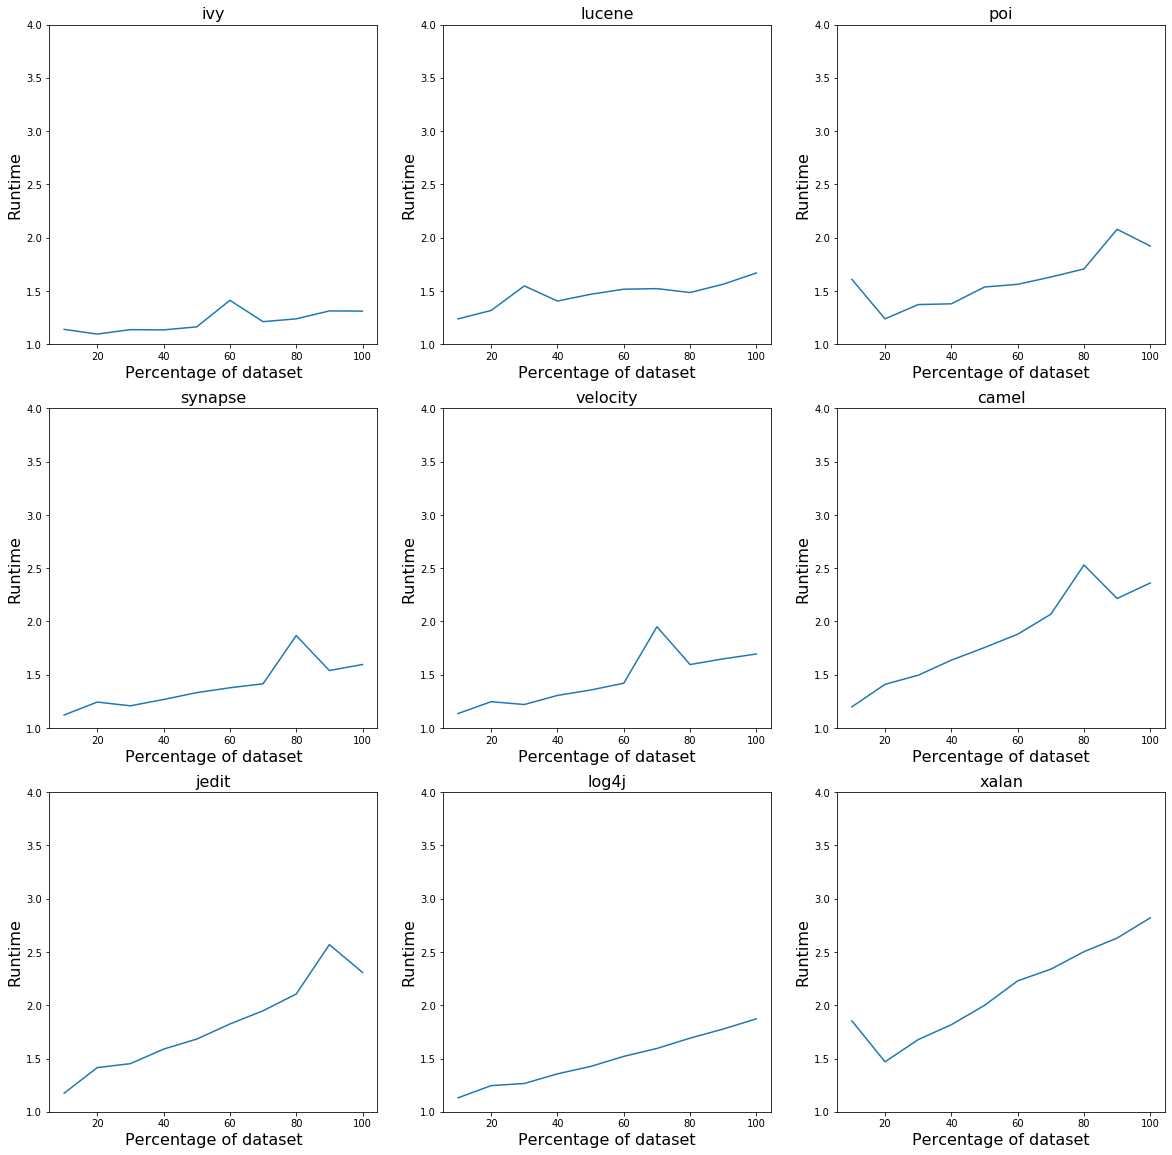

In [12]:
fig = plt.figure(figsize=(20, 20))
fig.tight_layout()
i = 1

for key in file_dic.keys():
    if i == 10:
        break
        
    times = run_scalability_tests(key)
    print(max(times))
    plt.subplot(3, 3, i)
    plt.gca().set_title(key, fontsize=16)
    plt.gca().set_xlabel('Percentage of dataset', fontsize=16)
    plt.gca().set_ylabel('Runtime', fontsize=16)
    plt.gca().set_ylim([1, 4])
    plt.plot(range(10, 101, 10), times)
    
    i += 1

## LipschitzLR

In [64]:
def train_with_lipschitz(filename, epochs=10, layers=4, lipschitz=True):
    paths = [os.path.join(base_path, file_name) for file_name in file_dic[filename]]
    train_df = pd.concat([pd.read_csv(path) for path in paths[:-1]], ignore_index=True)
    test_df = pd.read_csv(paths[-1])
    
    train_df, test_df = train_df.iloc[:, 3:], test_df.iloc[:, 3:]
    train_size = train_df["bug"].count()
    df = pd.concat([train_df, test_df], ignore_index=True)
    df['bug'] = df['bug'].apply(lambda x: 0 if x == 0 else 1)
    
    train_data = df.iloc[:train_size, :]
    test_data = df.iloc[train_size:, :]
    
    X_train = train_data[train_data.columns[:-2]]
    y_train = train_data['bug']
    X_test = test_data[test_data.columns[:-2]]
    y_test = test_data['bug']
    
    frac = sum(y_train) / len(y_train)
    weights = np.array([1., 10. / frac])
    
    m = X_train.shape[0]
    L = 1. / (2 * m) * (np.linalg.norm(X_train.iloc[np.where(y_train == 0)]) + 10. / frac * np.linalg.norm(X_train.iloc[np.where(y_train == 0)]))
                
    model = Sequential()
    model.add(Dense(20, input_shape=(X_train.shape[1],), activation='relu', name='layer1'))
    
    for i in range(layers - 2):
        model.add(Dense(20, activation='relu', name='layer'+str(i+2)))
        
    model.add(Dense(1, activation='sigmoid', name='layer'+str(layers)))
    
    if lipschitz:
        model.compile(loss='binary_crossentropy', optimizer=SGD(lr=1./L), metrics=['accuracy'])
    else:
        model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=m, verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001)])
    y_pred = model.predict_classes(X_test)
    return d2h(y_test, y_pred)

In [70]:
vals = []
for i in range(50):
    vals.append(train_with_lipschitz('jedit'))

print('median d2h =', np.median(vals))

median d2h = 0.5250568928273904


In [71]:
vals = []
for i in range(50):
    vals.append(train_with_lipschitz('jedit', lipschitz=False))

print('median d2h =', np.median(vals))

median d2h = 0.7071067811865475


## Testing on poi

We want to see the ROC curve for a case where the AUC is high but d2h is also high (i.e., bad d2h)

TP = 98 | TN = 148 | FP = 13 | FN = 183
AUC = 0.6340045533918348
d2h = 0.464026173115887


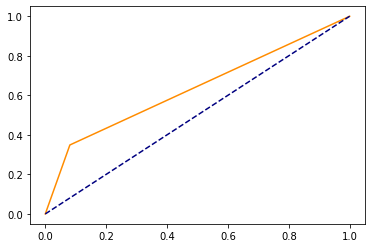

In [19]:
_, metric_ = run_on_dataset(filename='poi', metric='d2h', epochs=100, layers=4, draw_roc=True)

## 100 epochs

In [ ]:
for dataset in file_dic.keys():
    print(dataset)
    print('=' * len(dataset))
    for metric in ['popt20', 'popt', 'd2h', 'auc']:
        values = []
        for i in range(20):
            _, metric_ = run_on_dataset(filename=dataset, metric=metric, epochs=100, layers=4)
            values.append(metric_)
        
        print(metric, '-', statistics.median(values))
    
    print()

## Graph of loss over epochs

TP = 12 | TN = 285 | FP = 27 | FN = 28
ivy - 0.49874287229264924
TP = 136 | TN = 70 | FP = 67 | FN = 67
lucene - 0.4171950911477344
TP = 27 | TN = 156 | FP = 5 | FN = 254
poi - 0.6395412638482771
TP = 14 | TN = 163 | FP = 7 | FN = 72
synapse - 0.5927119526509443
TP = 74 | TN = 5 | FP = 146 | FN = 4
velocity - 0.6846536081695764
TP = 23 | TN = 758 | FP = 19 | FN = 165
camel - 0.620839866253932
TP = 5 | TN = 436 | FP = 45 | FN = 6
jedit - 0.39132672837868293
TP = 42 | TN = 14 | FP = 2 | FN = 147
log4j - 0.5570292952820965
TP = 151 | TN = 11 | FP = 0 | FN = 747
xalan - 0.5882057522787872


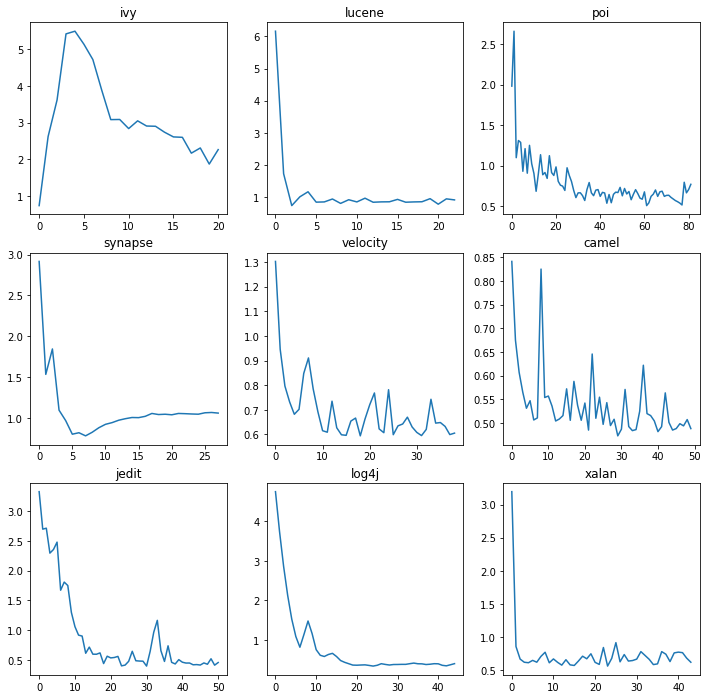

In [29]:
fig = plt.figure(figsize=(12, 12))
i = 1
for dataset in file_dic.keys():
    if i == 10:
        break
        
    history, _ = run_on_dataset(filename=dataset, metric='d2h', epochs=100, layers=4)
    plt.subplot(3, 3, i)
    plt.gca().set_title(dataset)
    plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'])
    print(dataset, '-', _)
    
    i += 1

plt.show()

ivy - 0.076
lucene - 0.434
poi - 0.093
synapse - 0.189
velocity - 0.597
camel - 0.157
jedit - 0.111
log4j - 0.18
xalan - 0.21


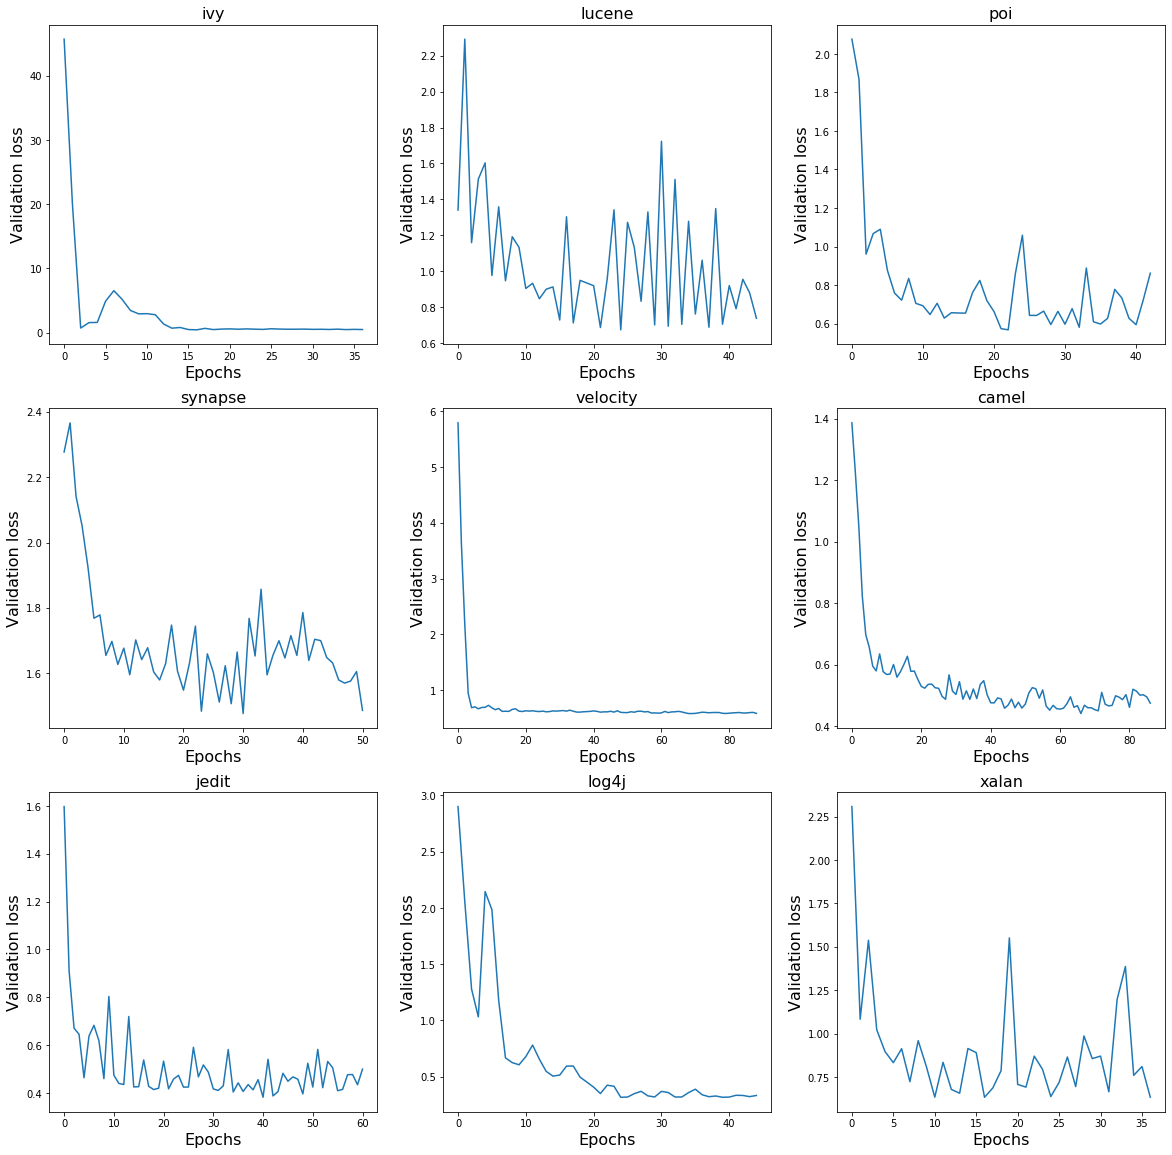

In [15]:
fig = plt.figure(figsize=(20, 20))
fig.tight_layout()
i = 1
for dataset in file_dic.keys():
    if i == 10:
        break
        
    history, _ = run_on_dataset(filename=dataset, metric='popt20', epochs=100, layers=4)
    plt.subplot(3, 3, i)
    plt.gca().set_title(dataset, fontsize=16)
    plt.gca().set_xlabel('Epochs', fontsize=16)
    plt.gca().set_ylabel('Validation loss', fontsize=16)
    plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'])
    print(dataset, '-', _)
    
    i += 1

plt.show()

## Weighted loss

In [15]:
i = 1
for dataset in file_dic.keys():
    if i == 10:
        break
    
    vals = []
    for i in range(20):
        _, metric_ = run_on_dataset(filename=dataset, metric='popt20', epochs=100, layers=4, weighted=True)
        vals.append(metric_)
        
    print(dataset, '-', np.median(vals))
    
    i += 1

plt.show()

ivy - 0.168
lucene - 0.472
poi - 0.378
synapse - 0.189
velocity - 0.597
camel - 0.1605
jedit - 0.10350000000000001
log4j - 0.1855
xalan - 0.1855
xerces - 0.4485


## Individual metrics

In [83]:
for dataset in file_dic.keys():
    _, metric = run_on_dataset(dataset, metric='popt20', epochs=100, layers=4)
    print(dataset, '-', metric)

/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ryedida/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ivy - 0.185
lucene - 0.689
poi - 0.233
synapse - 0.256
velocity - 0.581
camel - 0.329
jedit - 0.053
log4j - 0.157
xalan - 0.2
xerces - 0.659


In [66]:
for dataset in file_dic.keys():
    _, metric = run_on_dataset(dataset, metric='popt', epochs=100, layers=4)
    print(dataset, '-', metric)

ivy - 0.5054103669860661
lucene - 0.48247296971697456
poi - 0.5312047419205813
synapse - 0.47379493588350374
velocity - 0.34109125924007005
camel - 0.5319846205527903
jedit - 0.3558353507850208
log4j - 0.5359566971857821
xalan - 0.502087093368275
xerces - 0.4825217365370591


In [61]:
for dataset in file_dic.keys():
    _, metric = run_on_dataset(dataset, metric='d2h', epochs=100, layers=4)
    print(dataset, '-', metric)

ivy - 0.40551167546065947
lucene - 0.43130880283353884
poi - 0.6195936180032313
synapse - 0.4489572935881057
velocity - 0.6811849378866204
camel - 0.620839866253932
jedit - 0.28652989663328543
log4j - 0.6457255502460676
xalan - 0.6984451168290285
xerces - 0.6731431100575916


In [80]:
for dataset in file_dic.keys():
    _, metric = run_on_dataset(dataset, metric='auc', epochs=100, layers=4)
    print(dataset, '-', metric)

ivy - 0.5775641025641025
lucene - 0.5011865808493042
poi - 0.5001657788289383
synapse - 0.5577291381668946
velocity - 0.391110545084055
camel - 0.5360326131602727
jedit - 0.6295596295596295
log4j - 0.5825066137566137
xalan - 0.5406458797327394
xerces - 0.5552836164699108
